# Connectivity

Traditional multivariate fMRI techniques focus on the information present in patterns of activity in localized regions (ROIs or searchlights). Sometimes, the relevant information may be represented across a network of brain regions and thus would not be identified via ROI analysis or searchlights. Functional connectivity measures help examine information at a global level, in regions that are far apart, by focusing on network interaction rather than spatial localization. When performing connectivity analyses, BOLD timeseries are compared across regions (usually with correlation) and the strength of the relationship determines their functional connectivity. By including or excluding stimulus/task variables, we can study the modulation of connectivity by different cognitive states.

We are going to cover connectivity analysis over the next two notebooks, starting in this notebook with more basic ROI-level, task-based, and background connectivity. The next notebook will cover whole-brain connectivity analyses.  


## Goal of this script
>Learn how to run seed-based connectivity analyses.  
>Learn to use an atlas to get parcels and define seeds.  
>Investigate how attention modulates connectivity.


## Table of Contents
[1. Data loading](#load_data)  
>[1.1 Create stimulus labels and time-shift](#time_shift)  
>[1.2 Examine the header file](#header_info)  
>[1.3 Plot the stimulus labels](#stim_labels)  
>[1.4 Mask and extract the whole-brain data](#mask)

[2. Create a seed](#seed)
>[2.1 Create a spherical ROI](#ROI_sphere)    
>[2.2 Plot the bold signal for the mask](#mask_signal)

[3. Compute the correlation matrix](#correlation_matrix)  
>[3.1 Plot the seed correlations](#plot_seed)

[4. Creating a seed from an atlas](#ROI_atlas)  
>[4.1 Compute connectivity across parcels](#parcel_corr) 

[5. Background connectivity](#back_conn)  

[6. Group analyses](#group)
### Exercises:  
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9)  [10](#ex10)   [11](#ex11)  

>[Novel contribution](#novel) 

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import os 
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import brainiak.utils.fmrisim as sim

from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
from utils import shift_timing

%matplotlib inline
sns.set(palette="colorblind",style = 'white', context='notebook', rc={"lines.linewidth": 2})

**Dataset:** The dataset we will be using was collected as part of a study on attention and memory ([Hutchinson et al., 2016](https://www.ncbi.nlm.nih.gov/pubmed/26439270)). Below find the README file describing the dataset.
This dataset has been preprocessed with motion correction and linear detrending. Subjects were asked to attend to a scene on the right or on the left in each block.

**Attention and connectivity**

Our brain is constantly bombarded by sensory information from the world. Attention refers to the set of cognitive processes that filter this input based on what is salient (e.g., a police siren) and what is relevant (e.g., faces when looking for a friend). Attention biases our behavior and conscious awareness towards these properties of the world and reduces distraction by other properties. At the neural level, attention is controlled by parietal and frontal cortices [(Corbetta and Shulman, 2002)](https://www.ncbi.nlm.nih.gov/pubmed/11994752), which modulate processing in sensory systems, enhancing attended information and suppressing unattended information [(Noudoost et al., 2010)](https://www.ncbi.nlm.nih.gov/pubmed/20303256). Thus, to study the impact of attention on perceptual processing, we need to examine not just a localized brain region but how these regions interact with each other ([Saalman et al., 2007](https://www.ncbi.nlm.nih.gov/pubmed/17569863); [Gregoriou et al., 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2849291/); [Al-Aidroos et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/22908274)). In this case, traditional MVPA techniques that examine patterns of activity in local brain regions will not be sufficient and a more global analysis will be helpful. The covarying response of two or more brain regions becomes critical in this case, and thus functional connectivity measures are important in studying these phenomena.

## 1. Data loading <a id="load_data"></a>

Load the preprocessed data for subject 1.

In [2]:
from utils import latatt_dir
assert os.path.exists(latatt_dir)

dir_time = os.path.join(latatt_dir, 'onsets', 'fsl')
dir_motion = os.path.join(latatt_dir, 'processed_data', 'motionnuisance')
dir_motion_background = os.path.join(latatt_dir, 'processed_data', 'background')

sub = 'sub01'
num_runs = 1
TR = 1.5 # Duration of 1 TR in seconds
scan_duration = 540 # Duration of the scan in seconds

# Shift the data a certain amount
shift_size = 2

**Self-Study:** Explore the data

**Exercise 1**:<a id="ex1"></a> Carefully read the README file in `latatt_dir`. What is different between bg_image and raw_hires?


In [3]:
header_file=os.path.join(latatt_dir,'README.txt')
!head -100 $header_file

Data collected by: 	Ben Hutchinson, Northeastern University

Task:
This is a simple localizer dataset consisting of 30 subjects. Each subject has one functional run of 364 (raw) or 360 (preprocessed) TRs, during which s/he viewed sequences of scene images presented in the periphery (while subjects were instructed to maintain central fixation; eye tracking data available upon request). For each block, subjects were cued (via a centrally presented visual word) to attend to scenes appearing on either the left or right side of space, and to only perform the visual judgment task on those scenes while disregarding those on the other side of space. The task was to perform a 'manmade/natural' judgement for each scene (press one of two keys indicating if the scene consisted of primarily manmade or natural elements). The functional run contains 18 blocks (9 left, 9 right). Each block contains 12 scene pairs presented for 600ms, followed by an inter-event interval of 900ms, for a total of 18 seco

**A:**  

raw_hires is the set of the raw hi res images belonging to each subject

bg_image is the standard space average of the hi res anatomical images of all subjects.

### 1.1 Create stimulus labels and time-shift <a id="time_shift"></a>

From the stimulus timing files, we need to create labels for each TR in the BOLD data. We did this exercise for the VDC dataset in notebook 02-data-handling. You can repeat those steps to create labels for every TR.  

As we have FSL onset files for this dataset, there is an alternative way to create labels for every TR using `fmrisim` in BrainIAK. This involves calling `generate_stimfunction` and then `shift_timing`, which we defined in `utils`.

**Self-study:** What does `generate_stimfunction` do?

<div class="alert alert-block alert-info"> 
<strong> To time-shift or not?</strong> In traditional MVPA analysis, we timeshift the BOLD signal to account for the hemodynamic lag. In functional connectivity analysis, time-shifting is sometimes not done to ensure that the voxels being compared are similar before, during, and after the stimulus has been shown. If you do not want to time-shift your data then set the `shift_size = 0`.

<strong>Note:</strong> In this notebook, we are setting `shift_size=2`.
</div>

In [4]:
# Use the utilities from the simulator to create an event time course based on an FSL onset file

# Rightward attention blocks.
right_stimfunction = sim.generate_stimfunction(
    onsets='', 
    event_durations='', 
    total_time=scan_duration,
    temporal_resolution=1/TR, 
    timing_file=(dir_time + f'/{sub}/right.txt')
)

# Leftward attention blocks.
left_stimfunction  = sim.generate_stimfunction(
    onsets='', 
    event_durations='', 
    total_time=scan_duration,
    temporal_resolution=1/TR, 
    timing_file=(dir_time + f'/{sub}/left.txt')
)


# Shift the timecourses to account for the hemodynamic lag.
right_stim_lag = shift_timing(right_stimfunction, shift_size)
left_stim_lag = shift_timing(left_stimfunction, shift_size)

### 1.2 Examine the header file<a id="header_info"></a>

We have been loading nifti files in all previous notebooks. There is useful information in the header that you should examine to learn about the data organization and shape. You can find the voxel size (mm) and the transform space of the data set. More information can be found [here.](http://nipy.org/nibabel/gettingstarted.html)

In [5]:
# Get the nifti object
nii = nib.load(dir_motion + f'/{sub}.nii.gz')
hdr=nii.header
print(hdr)
print(f'Voxel size in {hdr.get_xyzt_units()[0]}, time in {hdr.get_xyzt_units()[-1]}')

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  45  54  45 360   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  4.  4.  4.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1470.0978
cal_min         : -1458.5084
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-4.  0.  

### 1.3 Plot the stimulus labels<a id="stim_labels"></a>

In this experiment there are two conditions (attend left and attend right), and each one condition has a separate timing file.

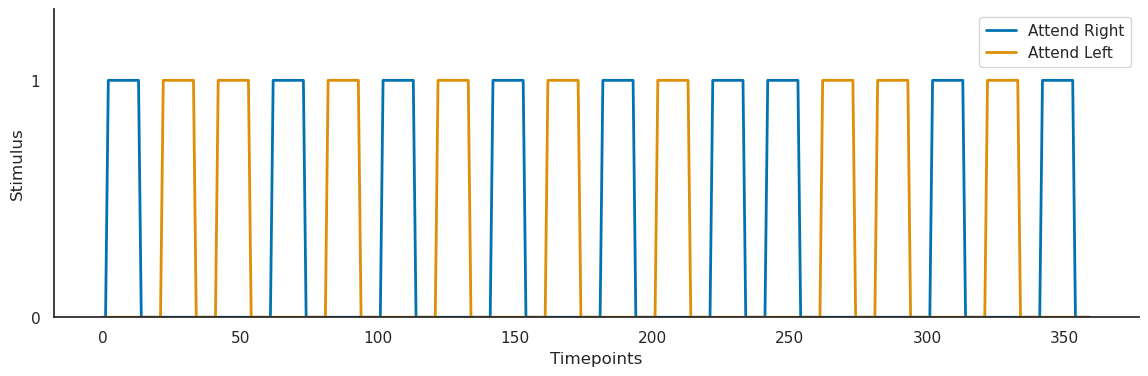

In [6]:
# Plot the stim time course. 
f, ax = plt.subplots(figsize=(14, 4))

ax.plot(right_stim_lag)
ax.plot(left_stim_lag)
ax.set_yticks([0,1])
ax.set_xlabel('Timepoints')
ax.set_ylabel('Stimulus')
ax.legend(('Attend Right', 'Attend Left'), loc='upper right')
ax.set_ylim(0, 1.3)
sns.despine()

### 1.4.  Mask and extract the whole-brain data <a id="mask"></a>

In previous notebooks, we extracted brain data with a mask. The mask was either an ROI or the whole brain. Both of these masks were already created for you. Here we show you a different way, using nilearn, to create a mask from a dataset and then extract the data from the mask. This function can z-score the data as well. More information can be found [here](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html). We then plot the time course of a few voxels.

In [7]:
# Init a masker object that also standardizes the data
masker_wb = input_data.NiftiMasker(
    standardize=True,  # Are you going to zscore the data across time?
    t_r=1.5, 
    memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
    memory_level=1,  # How much memory will you cache?
    verbose=0
)

# Pull out the time course for voxel
bold_wb = masker_wb.fit_transform(nii)
bold_wb_r = bold_wb[(right_stim_lag==1),:]
bold_wb_l = bold_wb[(left_stim_lag==1),:]

print(f'whole brain bold time series shape: {np.shape(bold_wb)}')
print(f'whole brain bold time series, attend left shape: {np.shape(bold_wb_l)}', )
print(f'whole brain bold time series, attend right shape: {np.shape(bold_wb_r)}')



whole brain bold time series shape: (360, 43642)
whole brain bold time series, attend left shape: (108, 43642)
whole brain bold time series, attend right shape: (108, 43642)


Text(0.5, 0, 'Timepoints')

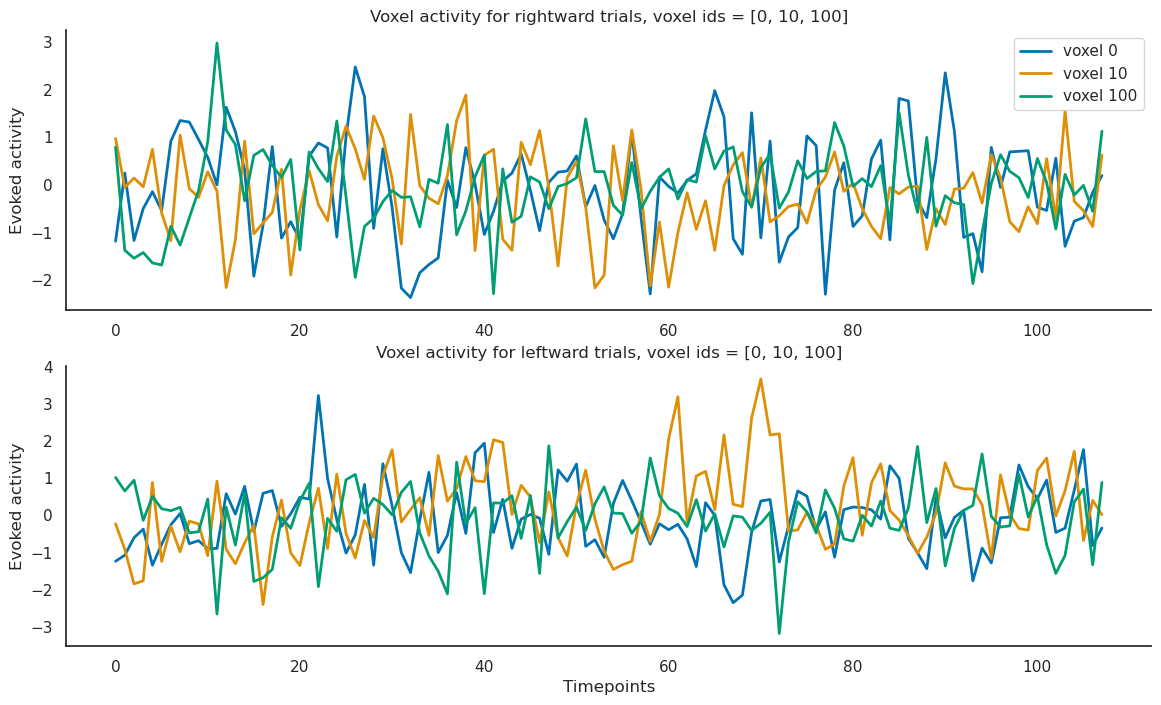

In [8]:
"""
Plot the timeseries for a few voxels
"""
voxel_ids = [0,10,100]

f, ax = plt.subplots(2,1,figsize=(14, 8))
ax[0].set_title(f'Voxel activity for rightward trials, voxel ids = {str(voxel_ids)}')
ax[0].plot(bold_wb_r[:, voxel_ids])
ax[0].legend(('voxel 0', 'voxel 10', 'voxel 100'))
ax[0].set_ylabel('Evoked activity')
ax[0].set_xlabel('')
sns.despine()
ax[1].set_title(f'Voxel activity for leftward trials, voxel ids = {str(voxel_ids)}')
ax[1].plot(bold_wb_l[:, voxel_ids])
ax[1].set_ylabel('Evoked activity')
ax[1].set_xlabel('Timepoints')

## 2. Create a seed  <a id="seed"></a>

At this stage, we have loaded the whole-brain data for the attend-left and attend-right conditions. To examine the effects of attention, we are going to create seed ROIs and correlate their activity with other voxels in the brain. For any voxels that are correlated with a seed ROI, we can infer that they are functionally connected.

### 2.1 Create a spherical ROI  <a id="ROI_sphere"></a>

Let's create an ROI to define the parahippocampal place area (PPA), a scene selective region, which is likely important since scene stimuli were presented. The data are currently in MNI space, a standardized anatomical space that allows us to compare individual anatomy to a common, averaged space and use coordinates in MNI space to identify regions (approximately) in individual participants.

**Exercise 2:**<a id="ex2"></a> Use this article to determine the center coordinates for the left and right PPA (use the co-ordinates based on the MNI average, reported in the methods section): Park, S., & Chun, M. M. (2009). Different roles of the parahippocampal place area (PPA) and retrosplenial cortex (RSC) in panoramic scene perception. NeuroImage, 47(4), 1747–1756. https://doi.org/10.1016/j.neuroimage.2009.04.058. Note: they use asymmetric ROI coordinates for the left and right PPA.

In [9]:
# Specify the center of the left and right ROIs
coords_lPPA = [( -27, -46, -15)]
coords_rPPA = [(30, -44, -14)]

Nilearn has some powerful tools for drawing ROIs. These functions allow you to flexibly identify ROIs of any shape and have multiple parameters that allow for smoothing, detrending, filtering and standardization. However, it is easy to get things wrong with these functions so use these parameters cautiously. Most research labs have well-defined processing pipelines with these parameters set for multiple studies to avoid too much variation across studies. We will play it safe and use the most basic [sphere ROI](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiSpheresMasker.html) function from nilearn.

### 2.2 Plot the bold signal for a mask  <a id="mask_signal"></a>

The average bold signal for all voxels in the left PPA mask is computed and plotted.

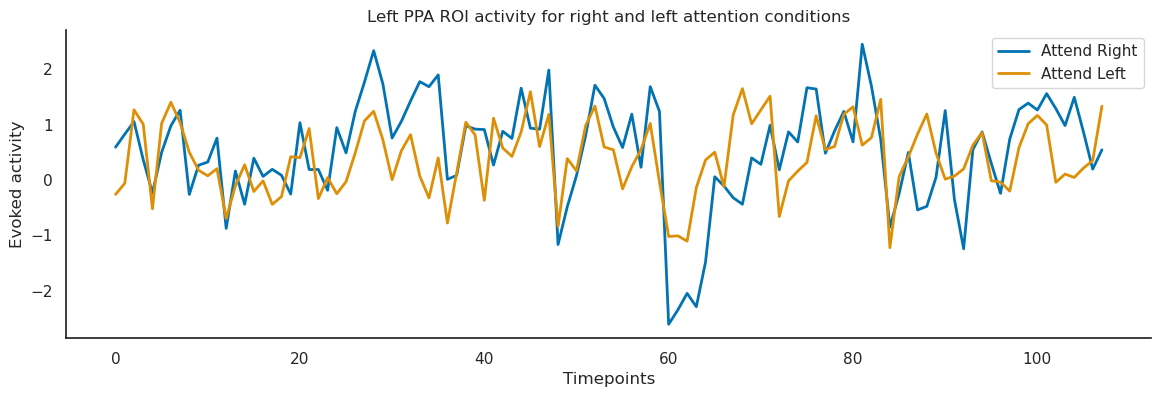

In [10]:
# Inititialize the masking object for the left PPA.

masker_lPPA = input_data.NiftiSpheresMasker(
    coords_lPPA, 
    radius=8, standardize=True, t_r=TR,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the left PPA
bold_lPPA = masker_lPPA.fit_transform(nii)

# Plot the data from the seed region for both attention condition
bold_lPPA_r = bold_lPPA[right_stim_lag == 1, :] # left PPA attend right
bold_lPPA_l = bold_lPPA[left_stim_lag == 1, :] # left PPA attend left
f, ax = plt.subplots(figsize=(14, 4))
ax.set_title('Left PPA ROI activity for right and left attention conditions')
ax.plot(bold_lPPA_r)
ax.plot(bold_lPPA_l)
ax.legend(('Attend Right', 'Attend Left'))
ax.set_ylabel('Evoked activity')
ax.set_xlabel('Timepoints')
sns.despine()

## 3. Compute the correlation matrix  <a id="correlation_matrix"></a>

We previously encountered correlation matrices in the `06-rsa` notebook on pattern similarity. Each cell in those matrices corresponded to the spatial correlation of the patterns of activity related to a pair of stimuli or tasks. We will again be using correlation matrices, but now for assessing temporal correlation or functional connectivity. Each cell in the functional connectivity matrix reflects the correlation of the BOLD timeseries between a pair of voxels or regions, and matrices can be calculated separately for each condition or even each trial.

Below we go through a slow loop-based way of calculating the correlation of every voxel in the brain with the PPA seed region during the attend right condition. We will revisit optimized ways of calculating correlations in the next exercise.

Analysis duration for 43642 voxels: 5.02s
Seed-based correlation transformed: min = -0.508; max = 0.954


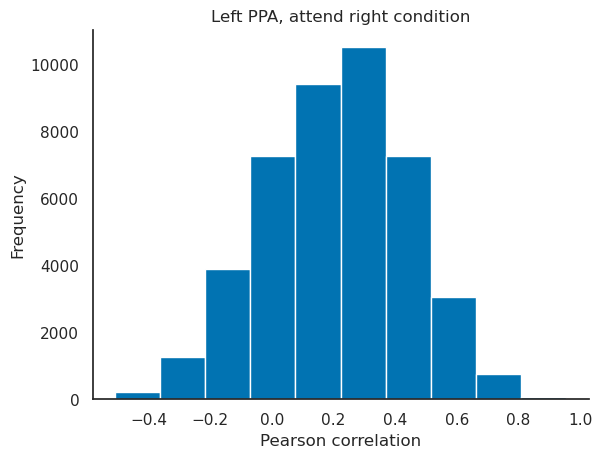

In [11]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
num_voxels = bold_wb_r.shape[1]
all_corr = np.zeros((num_voxels, 1))

bold_lPPA_r_vector = bold_lPPA_r.flatten() # vectorize
# Loop through all voxels in the brain
for v in range(num_voxels): 
    # Correlate each voxel in the brain with the PPA seed region during attend right
    all_corr[v] = np.corrcoef(bold_lPPA_r_vector, bold_wb_r[:, v])[0, 1]

end_time = time.time()
print(f'Analysis duration for {num_voxels} voxels: {np.round(end_time - start_time,2)}s')

print(f"Seed-based correlation transformed: min = {np.round(all_corr.min(),3)}; max = {np.round(all_corr.max(),3)}")

# A histogram is always a useful first way of looking at your data.
f, ax = plt.subplots(1,1)
ax.hist(all_corr)
ax.set_ylabel('Frequency')
ax.set_xlabel('Pearson correlation')
ax.set_title('Left PPA, attend right condition')

sns.despine()

We are going to be calculating seed-based correlations throughout this notebook, so let's make a function. It is also common to transform the correlations to a [Fisher-Z score](https://en.wikipedia.org/wiki/Fisher_transformation), as the bounded nature of Pearson correlation violates certain statistical assumptions. This generally does not have a big effect on the results.

In [12]:
def seed_correlation(wbBold, seedBold):
    
    """Compute the correlation between a seed voxel vs. other voxels 
    Parameters
    ----------
    wbBold [2d array], n_stimuli x n_voxels 
    seedBold [2d array] n_stimuli x 1

    Return
    ----------    
    seed_corr [2d array], n_stimuli x 1
    seed_corr_fishZ [2d array], n_stimuli x 1
    """
    
    num_voxels = wbBold.shape[1]
    seed_corr = np.zeros((num_voxels, 1))
    
    for v in range(num_voxels):    
        seed_corr[v] = np.corrcoef(seedBold.flatten(), wbBold[:, v])[0, 1]
        
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    
    return seed_corr, seed_corr_fishZ

Seed-based correlation Fisher-Z transformed: min = -0.561; max = 1.875


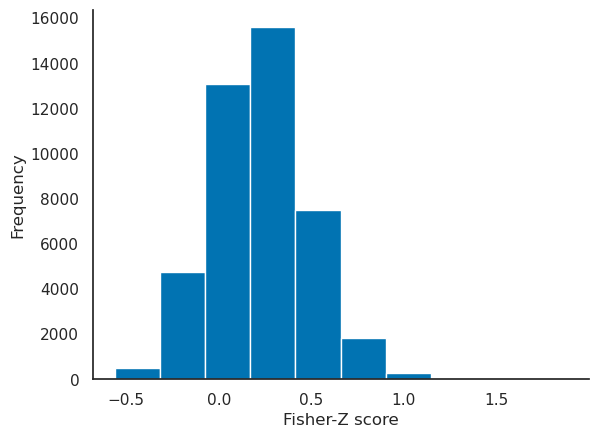

In [13]:
# Let's use the function and print out the range of results.
corr_lPPA_r, corr_fz_lPPA_r = seed_correlation(bold_wb_r, bold_lPPA_r)
print(f"Seed-based correlation Fisher-Z transformed: min = {np.round(corr_fz_lPPA_r.min(),3)}; max = {np.round(corr_fz_lPPA_r.max(),3)}")

# A histogram is always a useful first way of looking at your data.
f, ax = plt.subplots(1,1)
ax.hist(corr_fz_lPPA_r)
ax.set_ylabel('Frequency')
ax.set_xlabel('Fisher-Z score')
sns.despine()

In [14]:
# We can tranform the correlation array back to a Nifti image object that we can save
img_corr_lPPA_r = masker_wb.inverse_transform(corr_fz_lPPA_r.T)
img_corr_lPPA_r.to_filename('seed_rtstim.nii.gz')

### 3.1 Plot the seed correlations  <a id="plot_seed"></a>

We plot the seed correlation with every other voxel. For better visualization, we set a threshold, showing only voxels above the threshold. Typically, thresholds are chosen based on statistical significance. We have chosen the threshold arbitrarily below.

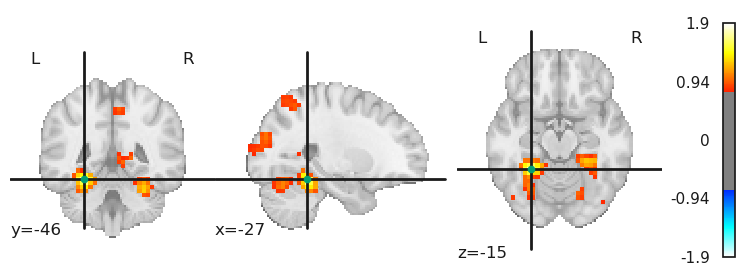

In [15]:
# Let's also visualize the correlation of the seed with every voxel
threshold = .8

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_lPPA_r, 
    threshold=threshold,
    cut_coords=coords_lPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=20
)

Here is a different way to plot the same information:

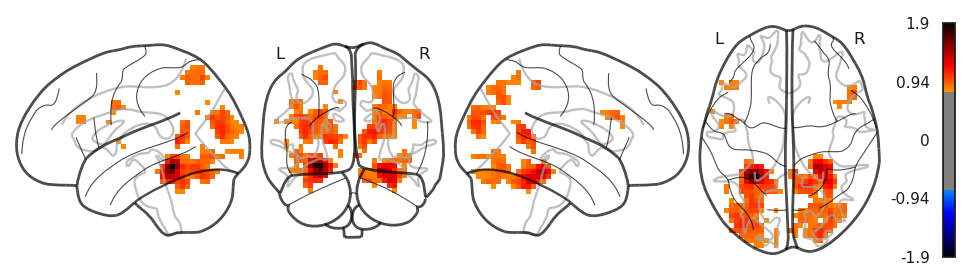

In [16]:
# Create a glass brain
plotting.plot_glass_brain(
    img_corr_lPPA_r, 
    threshold=threshold,
    colorbar=True, 
    plot_abs=False,
    display_mode='lyrz', 
)

**Exercise 3:**<a id="ex3"></a> Compute and plot the correlation with the left PPA when participants are attending to the scene in the left visual field. Threshold this plot at 0.7. 

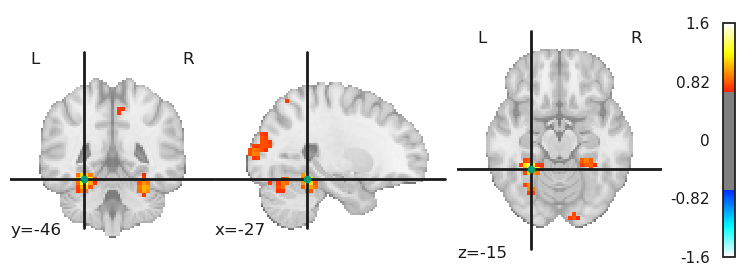

In [17]:
# Insert code here
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
corr_lPPA_l, corr_fz_lPPA_l = seed_correlation(bold_wb_l, bold_lPPA_l)

img_corr_lPPA_l = masker_wb.inverse_transform(corr_fz_lPPA_l.T)

# Let's also visualize the correlation of the seed with every voxel
threshold = .7

# Nilearn has useful tools for plotting our results as a map
l_map_ar = plotting.plot_stat_map(
    img_corr_lPPA_l, 
    threshold=threshold,
    cut_coords=coords_lPPA[0],
)
# Add the seed
l_map_ar.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=20
)

**Note:** The early stages of visual processing in the brain occur in the contralateral side. If you are viewing something in your left visual field, your right visual brain areas will show greater activity. See if you notice something similar in your results from this exercise.


**Exercise 4:**<a id="ex4"></a> Create a spherical ROI corresponding to the right PPA (using the coordinates you created earlier and a radius of 10). Compute correlations across the whole-brain in each of the 'attend left' and 'attend right' conditions and plot your results.   
_NB: Use the same plotting parameters (i.e., threshold, cut coordinates, colorbar) for each plot._

In [18]:
# Insert code here
masker_rPPA = input_data.NiftiSpheresMasker(
    coords_rPPA, 
    radius=10, standardize=True, t_r=TR,
    memory='nilearn_cache', memory_level=1, verbose=0
)

# Mask the epi data and get a time series for the left PPA
bold_rPPA = masker_rPPA.fit_transform(nii)

# Plot the data from the seed region for both attention condition
bold_rPPA_r = bold_lPPA[right_stim_lag == 1, :] # right PPA attend right
bold_rPPA_l = bold_lPPA[left_stim_lag == 1, :] # right PPA attend left

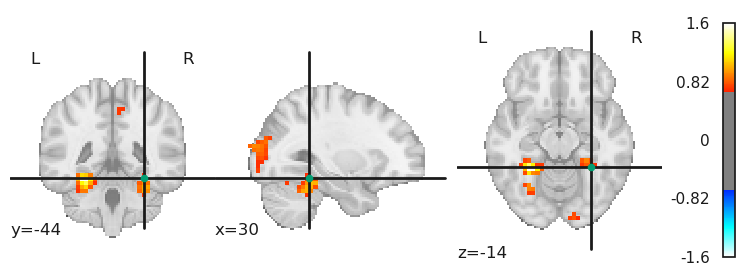

In [19]:
corr_rPPA_l, corr_fz_rPPA_l = seed_correlation(bold_wb_l, bold_rPPA_l)

img_corr_rPPA_l = masker_wb.inverse_transform(corr_fz_rPPA_l.T)

# Let's also visualize the correlation of the seed with every voxel
threshold = .7

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_rPPA_l, 
    threshold=threshold,
    cut_coords=coords_rPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_rPPA, 
    marker_color='g',
    marker_size=20
)

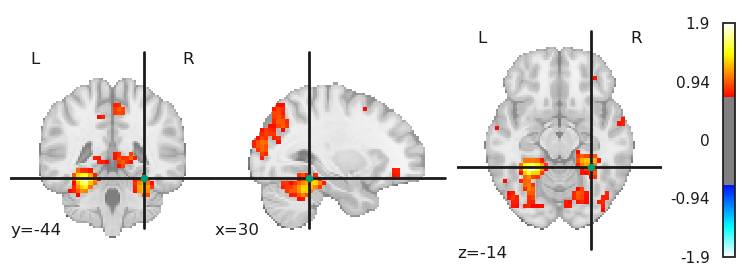

In [20]:

corr_rPPA_r, corr_fz_rPPA_r = seed_correlation(bold_wb_r, bold_rPPA_r)

img_corr_rPPA_r = masker_wb.inverse_transform(corr_fz_rPPA_r.T)

# Let's also visualize the correlation of the seed with every voxel
threshold = .7

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_rPPA_r, 
    threshold=threshold,
    cut_coords=coords_rPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_rPPA, 
    marker_color='g',
    marker_size=20
)

## 4. Creating a seed from an atlas  <a id="ROI_atlas"></a>

In addition to creating our own seed ROIs, we can use available atlases to extract ROIs.  Nilearn provides an easy way to accomplish this. In this next section you will:

1. Use Nilearn to import an [atlas parcellation](http://nilearn.github.io/modules/reference.html#module-nilearn.datasets). This will download and save in your home directory by default. 
2. Explore the atlas: plot the different parcels and get their labels.
3. Choose one parcel as the seed and extract the average BOLD signal over time from voxels in the parcel.
4. Perform correlation with remaining parcels or voxels.

Atlas path: <class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code    

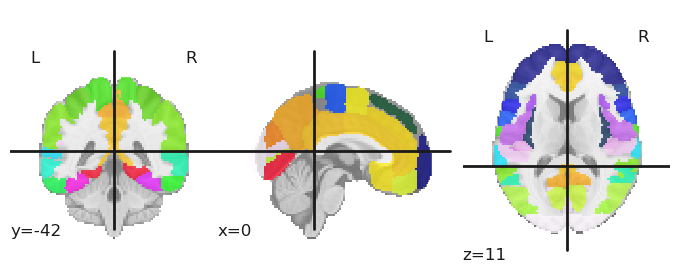

In [21]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# This is where the atlas is saved.
print(f"Atlas path: {atlas_filename}")

# Plot the ROIs
plotting.plot_roi(atlas_filename)
print('Harvard-Oxford cortical atlas')

# Print the labels
# Label 0 (Background) refers to the brain image, not background connectivity

# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_df = pd.DataFrame(atlas)
atlas_df['ROI_ID'] = np.arange(1,len(atlas_df)+1)
atlas_df.head()

# Create a masker object that we can use to select ROIs
atlas_masker = NiftiLabelsMasker(labels_img=atlas_filename)
print(atlas_masker.get_params())

# Apply the Harvard-Oxford atlas to the Nifti object so we can pull out data from single parcels/ROIs
bold_HarOxf = atlas_masker.fit_transform(nii)
print(f'Shape of parcellated bold time courses: {np.shape(bold_HarOxf)}')

**Exercise 5**: What do the dimensions of `bold_HarOxf` mean?

**A**:  
It means there are 360 time points and 48 ROIs.

In the previous analyses we calculated the average activity in a single seed region across time. However, Nilearn has tools to easily calculate the timecourse of activity across all of the ROIs that are supplied to the masker object.

All time points (360, 48)
Attend right trials: (108, 48)
(108, 1)
Posterior parahippocampal gyrus (region 35) rightward attention trials shape: (108, 1)


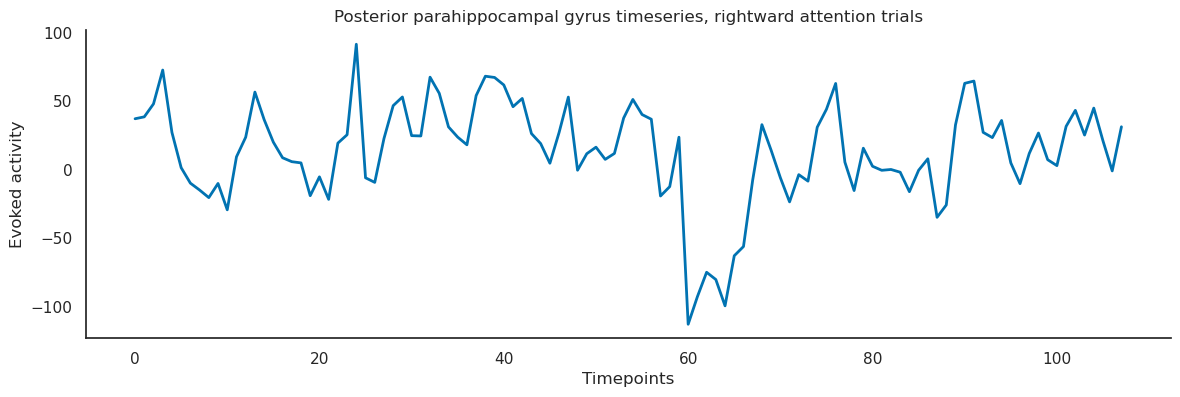

In [22]:
# Get data for rightward attention only
bold_HarOxf_r = bold_HarOxf[(right_stim_lag==1),:]

# What does our data structure look like?
print(f"All time points {bold_HarOxf.shape}")
print(f"Attend right trials: {bold_HarOxf_r.shape}")

# Pull out a single ROI corresponding to the posterior parahippocampal cortex
# Parahippocampal Gyrus, posterior division. 

roi_id = atlas_df[atlas_df['labels'] == "Parahippocampal Gyrus, posterior division"]['ROI_ID'] -1 # account for zero-based indexing
bold_HarOxf_pPHG_r = np.array(bold_HarOxf_r[:, roi_id])
print(bold_HarOxf_pPHG_r.shape)
print(f"Posterior parahippocampal gyrus (region 35) rightward attention trials shape: {bold_HarOxf_pPHG_r.shape}")

f, ax = plt.subplots(figsize=(14,4))
ax.plot(bold_HarOxf_pPHG_r)
ax.set_ylabel('Evoked activity')
ax.set_xlabel('Timepoints')
ax.set_title('Posterior parahippocampal gyrus timeseries, rightward attention trials')

sns.despine()

PHG correlation Fisher-z transformed: min = -0.685; max = 1.647


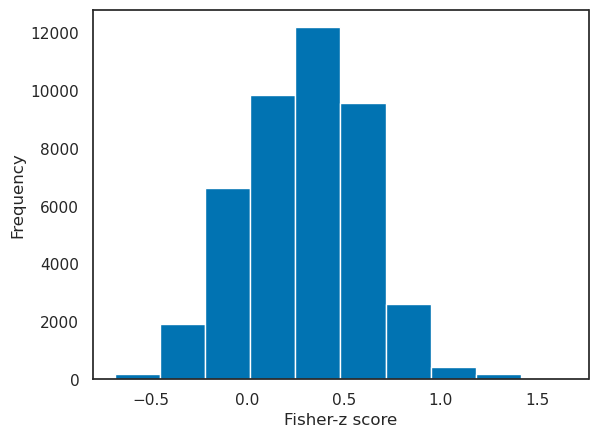

In [23]:
# Like before, let's correlate the whole-brain timeseries with the seed we have pulled out

corr_pPHG_r, corr_fz_pPHG_r = seed_correlation(bold_wb_r, bold_HarOxf_pPHG_r) 

# Print the range of correlations.
print(f"PHG correlation Fisher-z transformed: min = {np.round(corr_fz_pPHG_r.min(), 3)}; max = {np.round(corr_fz_pPHG_r.max(), 3)}")

# Plot a histogram
f, ax = plt.subplots()
ax.hist(corr_fz_pPHG_r)
ax.set_ylabel('Frequency');
ax.set_xlabel('Fisher-z score');

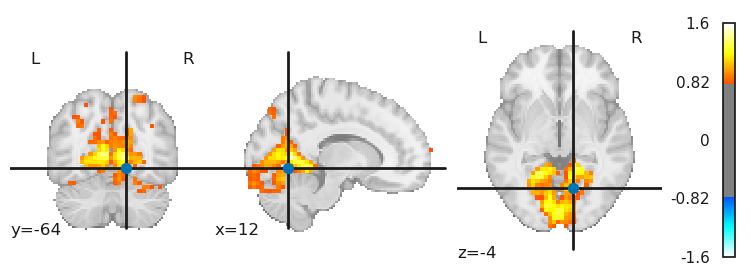

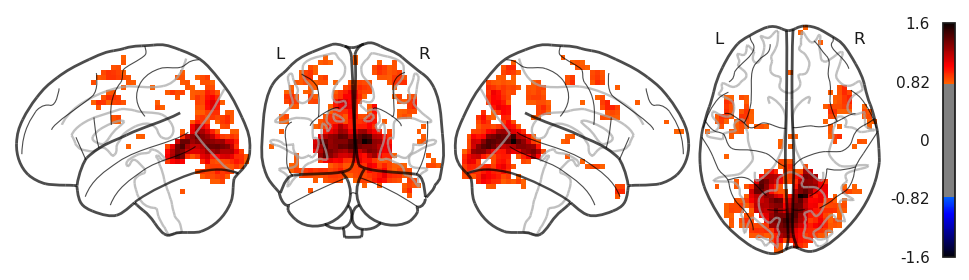

In [24]:
# Map back to the whole brain image
img_corr_pPHG_r = masker_wb.inverse_transform(
    corr_fz_pPHG_r.T
)

threshold = .8 

# Find the cut coordinates of this ROI, using parcellation.
# This function takes the atlas path and the hemisphere and outputs all centers of the ROIs
roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='right')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id, :]

# Plot the correlation as a map on a standard brain. 
results_pHG_r = plotting.plot_stat_map(
    img_corr_pPHG_r, 
    threshold=threshold,
    cut_coords=np.squeeze(roi_coord),
)
results_pHG_r.add_markers(
    marker_coords=roi_coord, 
    marker_color='b',
    marker_size=50
)

# Create a glass brain
plotting.plot_glass_brain(
    img_corr_pPHG_r, 
    threshold=threshold,
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False
)

### 4.1 Compute connectivity across parcels <a id="parcel_corr"></a>

In addition to one ROI, we can compute correlations across multiple brain regions. Nilearn has a [function](http://nilearn.github.io/modules/reference.html#module-nilearn.connectome) to do this quite easily. This will be useful when we want to study attention in different brain regions.

We will also plot the connectivity matrices using a few different ways.

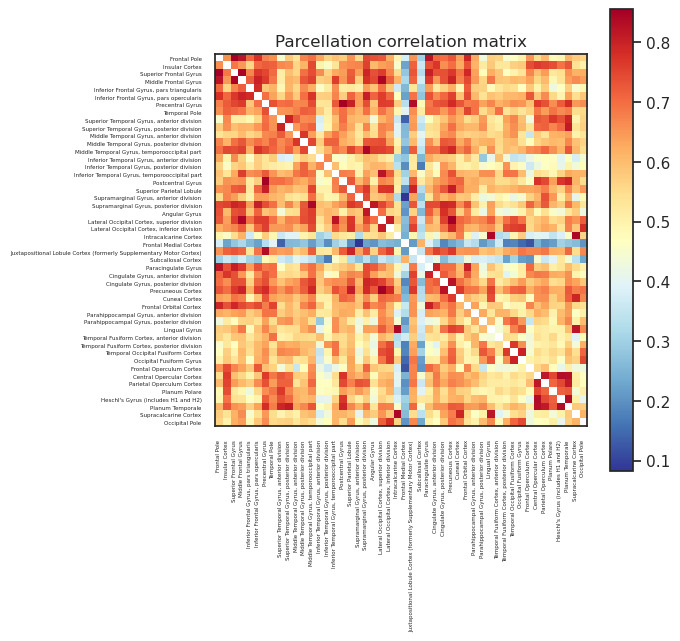

In [25]:
# Set up the connectivity object.
correlation_measure = ConnectivityMeasure(kind='correlation')

# Calculate the correlation of each parcel with every other parcel during attend-right condition
corr_mat_HarOxf_r = correlation_measure.fit_transform([bold_HarOxf_r])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(corr_mat_HarOxf_r, np.nan)

# Plot the correlation matrix
# The labels of the Harvard-Oxford Cortical Atlas that we are using 
# start with the background, hence we skip the first label
f, ax = plt.subplots(figsize=(6,6))
im=ax.imshow(corr_mat_HarOxf_r, interpolation='None', cmap='RdYlBu_r')
ax.set_yticks(range(len(atlas.labels[1:])))
ax.set_yticklabels(atlas.labels[1:], fontsize=4)
ax.set_xticks(range(len(atlas.labels[1:])))
ax.set_xticklabels(atlas.labels[1:], rotation=90, fontsize=4)
ax.set_title('Parcellation correlation matrix')
f.colorbar(im,ax=ax)

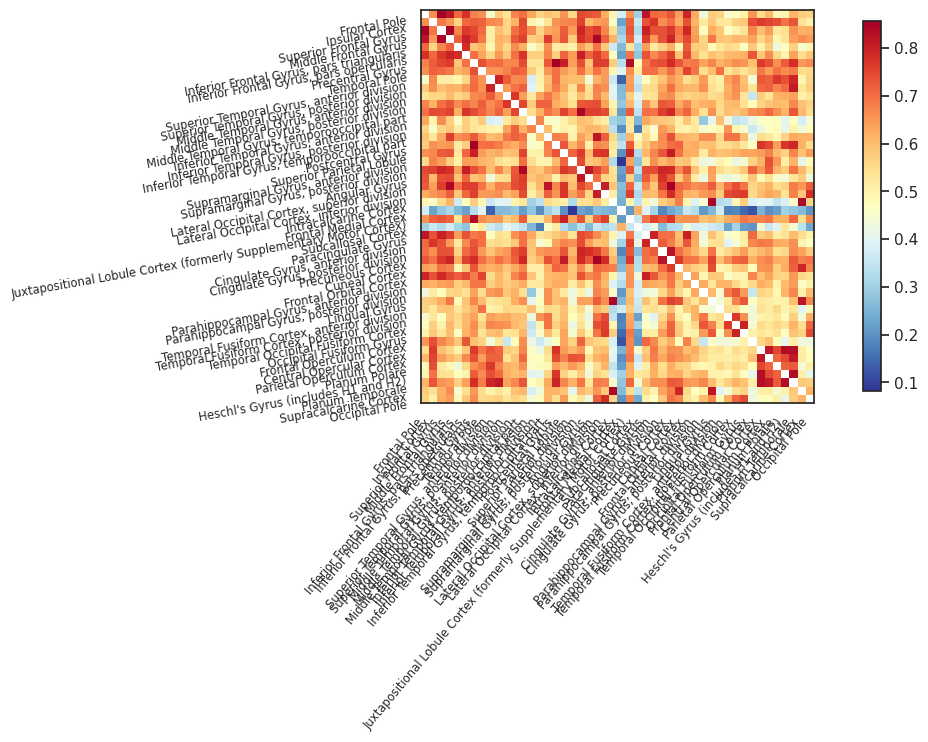

In [26]:
# Alternatively, we could use Nilearn's own plotting function
plotting.plot_matrix(
    corr_mat_HarOxf_r, 
    cmap='RdYlBu_r', 
    figure=(6,6), 
    auto_fit=False,
    labels=atlas.labels[1:],
    colorbar=True
)

**Exercise 6:**<a id="ex6"></a> We mentioned earlier that parietal and frontal cortices modulates sensory processing. You are now ready to examine this. Use a parcel from the **Middle Frontal Gyrus** as a seed and compute the **voxel-wise** correlation across the brain for the attend left and attend right conditions. 

When plotting the data, use `plotting.find_parcellation_cut_coords` to find the center of each ROI. Then use these coordinates to specify the `cut_coords` to center your plot on. Threshold your plots at 0.65.

Also note that roi_id does not align with the ROI names in the pandas dataframe above. Specifically, each roi_id is 1 less than the number reported in this table. That is because an ROI is not made for the background.

All time points (360, 48)
Attend right trials: (108, 48)
(108, 1)
Middle Frontal Gyrus rightward attention trials shape: (108, 1)
(43642, 1)


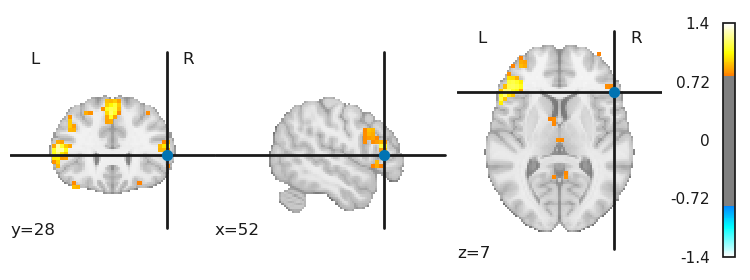

In [27]:
# Insert code here

# Get data for rightward attention only
bold_HarOxf_r = bold_HarOxf[(right_stim_lag==1),:]

# What does our data structure look like?
print(f"All time points {bold_HarOxf.shape}")
print(f"Attend right trials: {bold_HarOxf_r.shape}")


roi_id = atlas_df[atlas_df['labels'] == "Middle Frontal Gyrus"]['ROI_ID'] -1 # account for zero-based indexing
bold_HarOxf_pMFG_r = np.array(bold_HarOxf_r[:, roi_id])
print(bold_HarOxf_pMFG_r.shape)
print(f"Middle Frontal Gyrus rightward attention trials shape: {bold_HarOxf_pMFG_r.shape}")

corr_pMFG_r, corr_fz_pMFG_r = seed_correlation(bold_wb_r, bold_HarOxf_pMFG_r) 

print(np.shape(corr_fz_pMFG_r))
img_corr_pMFG_r = masker_wb.inverse_transform(
    corr_fz_pMFG_r.T
)

threshold = .8 

# Find the cut coordinates of this ROI, using parcellation.
# This function takes the atlas path and the hemisphere and outputs all centers of the ROIs
roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='right')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id, :]

# Plot the correlation as a map on a standard brain. 
results_pMFG_r = plotting.plot_stat_map(
    img_corr_pMFG_r, 
    threshold=threshold,
    cut_coords=np.squeeze(roi_coord),
)
results_pMFG_r.add_markers(
    marker_coords=roi_coord, 
    marker_color='b',
    marker_size=50
)


(108, 1)
Middle Frontal Gyrus rightward attention trials shape: (108, 1)
(43642, 1)


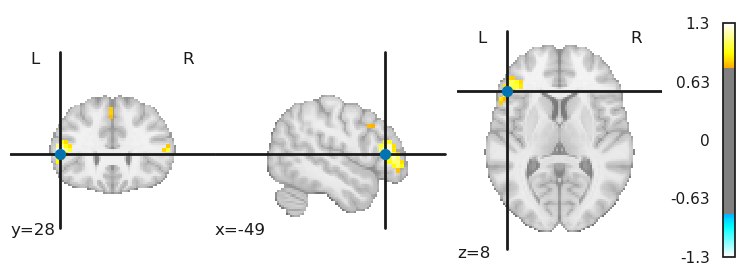

In [28]:
# Get data for leftward attention only
bold_HarOxf_l = bold_HarOxf[(left_stim_lag==1),:]

roi_id = atlas_df[atlas_df['labels'] == "Middle Frontal Gyrus"]['ROI_ID'] -1 # account for zero-based indexing
bold_HarOxf_pMFG_l = np.array(bold_HarOxf_l[:, roi_id])
print(bold_HarOxf_pMFG_l.shape)
print(f"Middle Frontal Gyrus rightward attention trials shape: {bold_HarOxf_pMFG_l.shape}")

corr_pMFG_l, corr_fz_pMFG_l = seed_correlation(bold_wb_l, bold_HarOxf_pMFG_l) 

print(np.shape(corr_fz_pMFG_l))
img_corr_pMFG_l = masker_wb.inverse_transform(
    corr_fz_pMFG_l.T
)

threshold = .8 

# Find the cut coordinates of this ROI, using parcellation.
# This function takes the atlas path and the hemisphere and outputs all centers of the ROIs
roi_coords = plotting.find_parcellation_cut_coords(atlas_filename,label_hemisphere='left')

# Pull out the coordinate for this ROI
roi_coord = roi_coords[roi_id, :]

# Plot the correlation as a map on a standard brain. 
results_pMFG_l = plotting.plot_stat_map(
    img_corr_pMFG_l, 
    threshold=threshold,
    cut_coords=np.squeeze(roi_coord),
)
results_pMFG_l.add_markers(
    marker_coords=roi_coord, 
    marker_color='b',
    marker_size=50
)

## 5. Background connectivity <a id="back_conn"></a>

There is a potential problem in analyzing functional connectivity during tasks. Consider brain regions A and B. Let's assume that our stimuli activate both regions. If we were to examine correlations between the regions, they would have strong connectivity, but not because they are necessarily communicating or interacting in any way. Rather, they share the stimulus as a third variable. One solution is to regress out the stimulus-evoked responses from our signal and re-examine the correlations between regions. If region A and B are still correlated, we are on more solid footing that they are functionally connected during the task. Insofar as this "background connectivity" differs between task conditions (e.g., attend left vs. right), we can conclude that the task is modulating the scaffold of noise correlations in the brain. To learn more about background connectivity, see this [review](https://doi.org/10.1126/science.1238409).

In background connectivity analysis, stimulus-driven activation is not the desired effect of interest, but potentially a confound. Thus, now we need to remove "stimulus confounds" before continuing. Lucky for us, the dataset in the directory `../processed_data/background/`  already has the evoked activity and other nuisance variables regressed out. We'll repeat the previous analyses for the left PPA on these data.

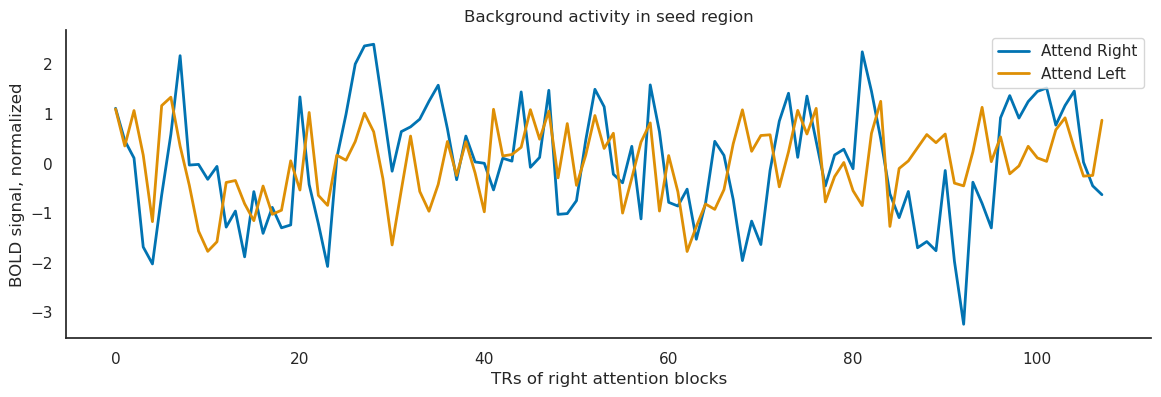

In [29]:
# Load in the data
sub = 'sub01'
epi_in_mcg = dir_motion_background + f'/{sub}.nii.gz'

# Get the seed data
bold_lPPA_mcg = masker_lPPA.fit_transform(epi_in_mcg)
bold_lPPA_r_mcg = bold_lPPA_mcg[right_stim_lag==1,:]
bold_lPPA_l_mcg = bold_lPPA_mcg[left_stim_lag==1,:]

# Get the whole brain data
bold_wb_mcg = masker_wb.fit_transform(epi_in_mcg)
bold_wb_r_mcg = bold_wb_mcg[right_stim_lag==1,:] 
bold_wb_l_mcg = bold_wb_mcg[left_stim_lag==1,:] 

# plot the data
f, ax = plt.subplots(figsize=(14,4))
plt.plot(bold_lPPA_r_mcg)
plt.plot(bold_lPPA_l_mcg)
ax.legend(('Attend Right', 'Attend Left'))
ax.set_ylabel('BOLD signal, normalized')
ax.set_xlabel('TRs of right attention blocks')
ax.set_title('Background activity in seed region')
sns.despine()

In [30]:
# Calculate the voxelwise seed-based correlation
corr_lPPA_r_mcg, corr_fz_lPPA_r_mcg  = seed_correlation(bold_wb_r_mcg, bold_lPPA_r_mcg)
corr_lPPA_l_mcg, corr_fz_lPPA_l_mcg  = seed_correlation(bold_wb_l_mcg, bold_lPPA_l_mcg)

# Make an image 
img_corr_fz_lPPA_r_mcg = masker_wb.inverse_transform(corr_fz_lPPA_r_mcg.T)
img_corr_fz_lPPA_l_mcg = masker_wb.inverse_transform(corr_fz_lPPA_l_mcg.T)

print('lPPA correlation Fisher-z transformed')
print("Attend right: min = %.3f; max = %.3f" % (
    corr_fz_lPPA_r_mcg.min(), corr_fz_lPPA_r_mcg.max()))
print("Attend left: min = %.3f; max = %.3f" % (
    corr_fz_lPPA_l_mcg.min(), corr_fz_lPPA_l_mcg.max()))



lPPA correlation Fisher-z transformed
Attend right: min = -0.823; max = 1.678
Attend left: min = -0.583; max = 1.425


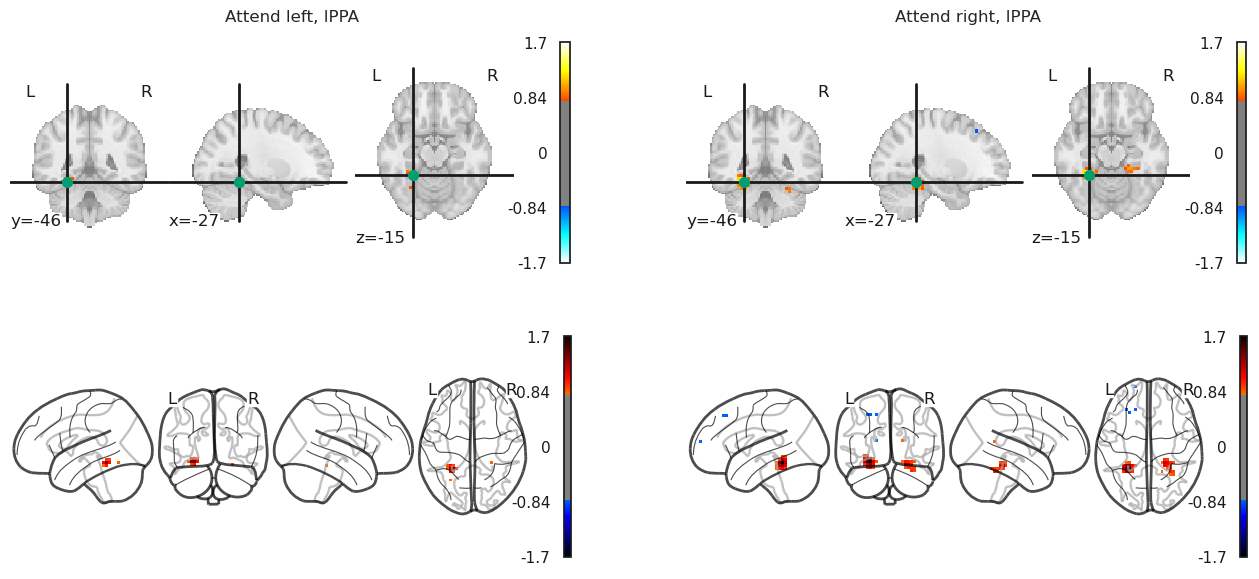

In [31]:
# Plot the correlation of each voxel in the brain with the seed
threshold = .8
vmax = np.max(np.stack([corr_fz_lPPA_r_mcg, corr_fz_lPPA_l_mcg]))

f, ax = plt.subplots(2, 2, figsize = (16, 7))

# Attend left
ax[0,0].set_title('Attend left, lPPA')

r_map = plotting.plot_stat_map(
    img_corr_fz_lPPA_l_mcg, 
    threshold=threshold, vmax=vmax, 
    cut_coords=coords_lPPA[0], 
    axes=ax[0,0]
)
r_map.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)
plotting.plot_glass_brain(
    img_corr_fz_lPPA_l_mcg, 
    threshold=threshold, vmax=vmax, 
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False, 
    axes=ax[1,0]
)

# Attend right
ax[0,1].set_title('Attend right, lPPA')
r_map = plotting.plot_stat_map(
    img_corr_fz_lPPA_r_mcg, 
    threshold=threshold, vmax=vmax, 
    cut_coords=coords_lPPA[0], 
    axes=ax[0,1]
)
r_map.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)
plotting.plot_glass_brain(
    img_corr_fz_lPPA_r_mcg, 
    threshold=threshold, vmax=vmax, 
    colorbar=True, 
    display_mode='lyrz', 
    plot_abs=False, 
    axes=ax[1,1]
)

**Exercise 7:**<a id="ex7"></a> Compare background connectivity (above) to the original left PPA spherical ROI result (from [3.1](#plot_seed)). Explain why this difference might exist.

**A:**   
This one shows some very very highly correlated areas and some negatively correlated areas. This happens because we removed the stimulus-evoked responses and are now left with areas that likely were background noise that get activated regardless of the stimulus. These are just general brain patterns and not what we need.

Make a correlation matrix with the background connectivity data for one condition (attend right).

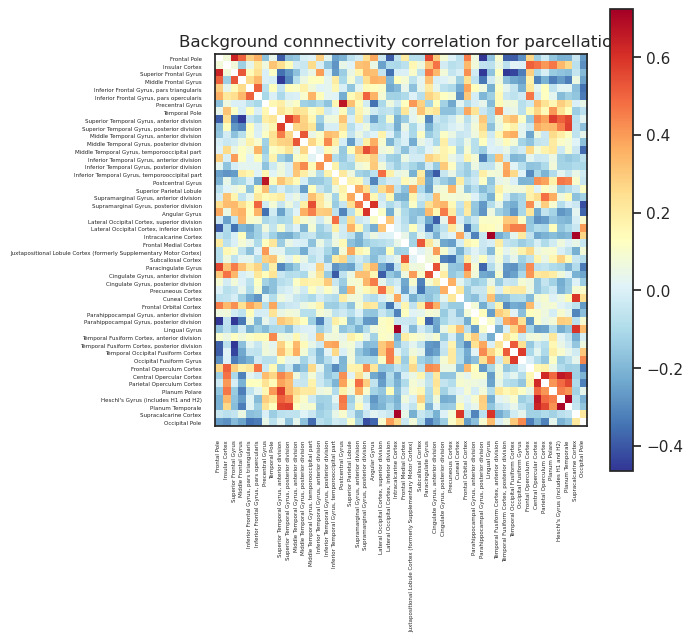

In [32]:
# Parcellate the time course to get the background connectivity parcels
bold_HarOxf_timeseries_mcg = atlas_masker.fit_transform(epi_in_mcg)
bold_HarOxf_timeseries_mcg_r = bold_HarOxf_timeseries_mcg[right_stim_lag==1, :]

correlation_matrix_mcg = correlation_measure.fit_transform([bold_HarOxf_timeseries_mcg_r])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix_mcg, np.nan)

# Plot the correlation matrix
f, ax =plt.subplots(figsize=(6,6))

# The labels we have start with the background (0), hence we skip the first label
ax.set_title('Background connnectivity correlation for parcellation')
im=ax.imshow(correlation_matrix_mcg, interpolation='None', cmap='RdYlBu_r')
ax.set_yticks(range(len(atlas.labels)-1))
ax.set_yticklabels(atlas.labels[1:],fontsize=4)
ax.set_xticks(range(len(atlas.labels)-1))
ax.set_xticklabels(atlas.labels[1:], rotation=90,fontsize=4)
f.colorbar(im,ax=ax)

**Exercise 8:**<a id="ex7"></a> Use a different atlas (use [`datasets.fetch_atlas_`](http://nilearn.github.io/modules/reference.html#module-nilearn.datasets) to look through other available atlases) and recompute the background connectivity matrix for both attend left and attend right conditions. Use an atlas that distinguishes ROIs between the left and right hemispheres and rearrange the labels so that all the ROIs from a hemisphere are grouped. What structure do you notice in the correlation matrix if any and what does it mean?

**A:**  
Both matrices show similar correlations regardless of whether they were under the left or right attend condition. This is expected as it is the background connectivity and we would want to regress out this "noise" when we truly want to see differences between right and left attend responses.

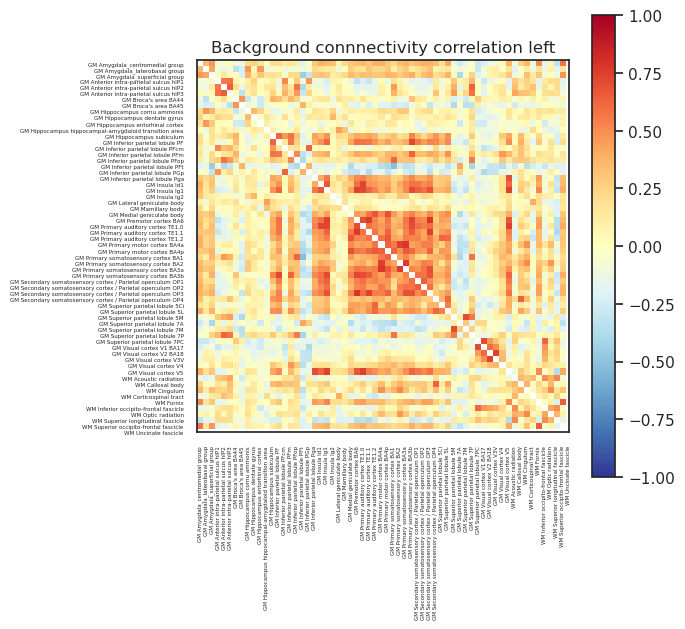

In [33]:
# Insert code here.
sub = 'sub01'
Jepi = dir_motion_background + f'/{sub}.nii.gz'

# peter recommended the Juelich Atlas

Jatlas = datasets.fetch_atlas_juelich('maxprob-thr25-2mm')
Jatlas_filename = Jatlas.maps

# Create a Pandas dataframe of the atlas data for easy inspection.
Jatlas_df = pd.DataFrame(Jatlas)


# Create a masker object that we can use to select ROIs
Jatlas_masker = NiftiLabelsMasker(labels_img=Jatlas_filename)

# Apply the J atlas to the Nifti object so we can pull out data from single parcels/ROIs
bold_J = Jatlas_masker.fit_transform(Jepi)

bold_J_l = bold_J[left_stim_lag==1, :]
bold_J_r = bold_J[right_stim_lag==1, :]

correlation = ConnectivityMeasure(kind='correlation')

Jcorrelation_matrix_l = correlation_measure.fit_transform([bold_J_l])[0]
Jcorrelation_matrix_r = correlation_measure.fit_transform([bold_J_r])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(Jcorrelation_matrix_l, np.nan)
np.fill_diagonal(Jcorrelation_matrix_r, np.nan)


# Plot the correlation matrix
f, ax =plt.subplots(figsize=(6,6))

# The labels we have start with the background (0), hence we skip the first label
ax.set_title('Background connnectivity correlation left')
im=ax.imshow(Jcorrelation_matrix_l, interpolation='None', cmap='RdYlBu_r', vmin = -1, vmax = 1)
ax.set_yticks(range(len(Jatlas.labels)-1))
ax.set_yticklabels(Jatlas.labels[1:],fontsize=4)
ax.set_xticks(range(len(Jatlas.labels)-1))
ax.set_xticklabels(Jatlas.labels[1:], rotation=90,fontsize=4)
f.colorbar(im,ax=ax)

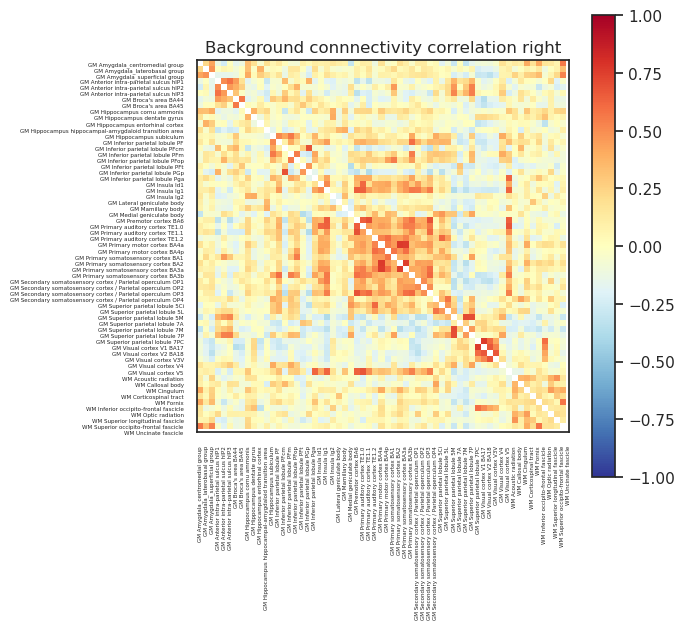

In [34]:
# Plot the correlation matrix
f, ax =plt.subplots(figsize=(6,6))

# The labels we have start with the background (0), hence we skip the first label
ax.set_title('Background connnectivity correlation right')
im=ax.imshow(Jcorrelation_matrix_r, interpolation='None', cmap='RdYlBu_r', vmin = -1, vmax = 1)
ax.set_yticks(range(len(Jatlas.labels)-1))
ax.set_yticklabels(Jatlas.labels[1:],fontsize=4)
ax.set_xticks(range(len(Jatlas.labels)-1))
ax.set_xticklabels(Jatlas.labels[1:], rotation=90,fontsize=4)
f.colorbar(im,ax=ax)

## 6. Group analyses <a id="group"></a>


**Exercise 9:**<a id="ex9"></a> Calculate and store the two matrices computed in [Exercise 8](#ex8) (functional connectivity separately for each attention condition) for all 30 participants using the **Harvard-Oxford Atlas**. Plot the average across participants for each condition.

Here are some suggested concrete steps to help you break down this task. We recommend you make at least the following functions to encapsulate some of these steps.

1. Create a function `get_data_timing` that takes `dir_time`, `sub`, `TR`, `scan_duration`, and `shift_size`, generates the stimulus functions for the attend left and attend right conditions, shifts the timing of these functions, and returns them.

2. Create a function `get_atlas_bold_data_labeled` that takes `dir_motion_background`, `sub`, `atlas_filename`, `stim_labels_l`, and `stim_labels_r`, and returns two arrays -- the masked bold data for the attend left and attend right conditions. 

3. Create a function `compute_connectivity_matrix` that takes the masked bold data for a single condition (from `get_atlas_bold_data_labeled`) and returns a parcel-by-parcel connectivity matrix.


In [35]:
# Insert card here.

def get_data_timing(dir_time, sub, TR, scan_duration, shift_size):
    """
    docstring is equivalent to 1 above.
    """
    # Use the utilities from the simulator to create an event time course based on an FSL onset file
    # Rightward attention blocks.
    right_stimfunction = sim.generate_stimfunction(
        onsets='', 
        event_durations='', 
        total_time=scan_duration,
        temporal_resolution=1/TR, 
        timing_file=(dir_time + f'/{sub}/right.txt')
    )

    # Leftward attention blocks.
    left_stimfunction  = sim.generate_stimfunction(
        onsets='', 
        event_durations='', 
        total_time=scan_duration,
        temporal_resolution=1/TR, 
        timing_file=(dir_time + f'/{sub}/left.txt')
    )


    # Shift the timecourses to account for the hemodynamic lag.
    right_stim_lag = shift_timing(right_stimfunction, shift_size)
    left_stim_lag = shift_timing(left_stimfunction, shift_size)
    
    return right_stim_lag, left_stim_lag

In [36]:
def get_atlas_bold_data_labeled(dir_motion_background, sub, atlas_filename, stim_labels_l, stim_labels_r):
    """
    docstring is equivalent to 2 above.
    """
    epi_in_mcg = dir_motion_background + f'/{sub}.nii.gz'
    # Create a masker object that we can use to select ROIs
    atlas_masker = NiftiLabelsMasker(labels_img=atlas_filename)

    # Apply the J atlas to the Nifti object so we can pull out data from single parcels/ROIs
    bold = atlas_masker.fit_transform(epi_in_mcg)

    bold_l = bold[left_stim_lag==1, :]
    bold_r = bold[right_stim_lag==1, :]
    return bold_l, bold_r

In [37]:
def compute_connectivity_matrix(bold_):
    """
    docstring is equivalent to 3 above.
    """
    correlation_measure = ConnectivityMeasure(kind='correlation')
    corr_mat = correlation_measure.fit_transform([bold_])[0]
    return corr_mat

In [38]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

corr_mat_l = []
corr_mat_r = []

subs = sorted([sub.split('.')[0] for sub in os.listdir(dir_motion_background)])

for sub in subs:
    stim_labels_r, stim_labels_l = get_data_timing(dir_time, sub, TR, scan_duration, shift_size)
    bold_l, bold_r = get_atlas_bold_data_labeled(dir_motion_background, sub, atlas_filename, stim_labels_l, stim_labels_r)
    corr_mat_l.append(compute_connectivity_matrix(bold_l))
    corr_mat_r.append(compute_connectivity_matrix(bold_r))
    
avgCorrmatL = np.mean(np.array(corr_mat_l), axis = 0)
avgCorrmatR = np.mean(np.array(corr_mat_r), axis = 0)

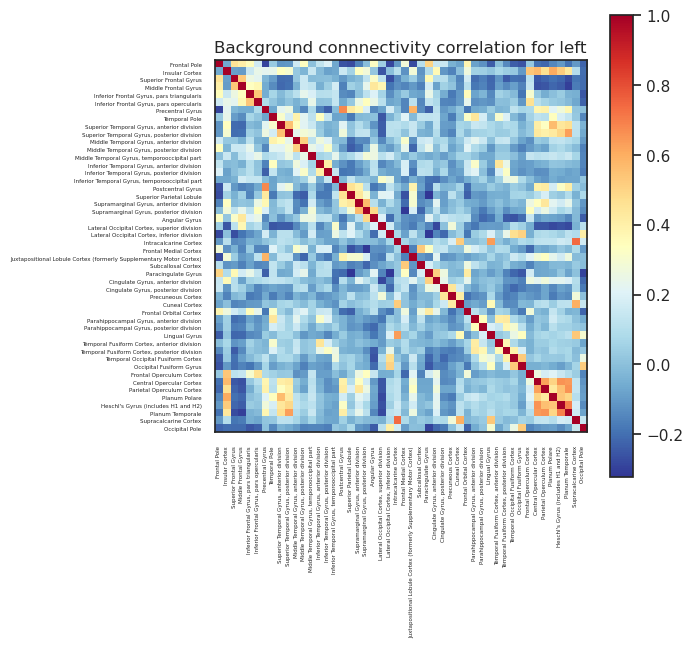

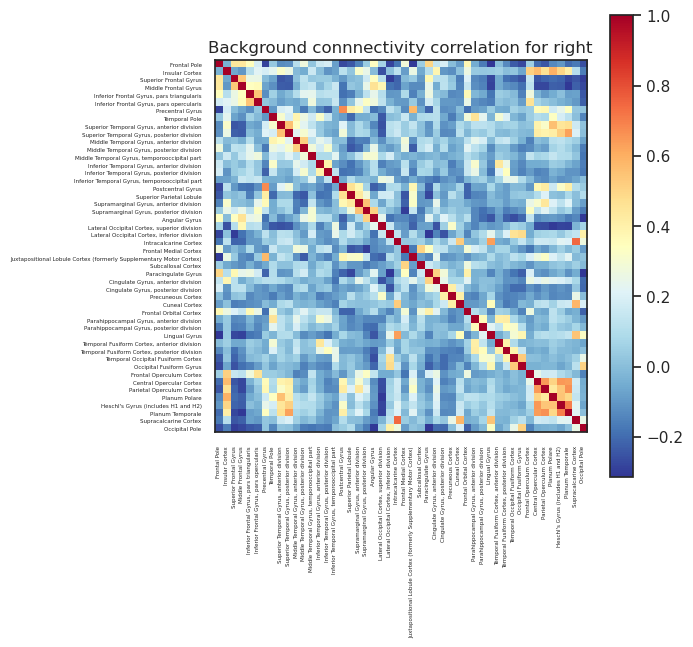

In [39]:
f, ax = plt.subplots(figsize = (6,6))

ax.set_title('Background connnectivity correlation for left')
im=ax.imshow(avgCorrmatL, interpolation='None', cmap='RdYlBu_r')
ax.set_yticks(range(len(atlas.labels)-1))
ax.set_yticklabels(atlas.labels[1:],fontsize=4)
ax.set_xticks(range(len(atlas.labels)-1))
ax.set_xticklabels(atlas.labels[1:], rotation=90,fontsize=4)
f.colorbar(im,ax=ax)


f, ax = plt.subplots(figsize = (6,6))

ax.set_title('Background connnectivity correlation for right')
im=ax.imshow(avgCorrmatR, interpolation='None', cmap='RdYlBu_r')
ax.set_yticks(range(len(atlas.labels)-1))
ax.set_yticklabels(atlas.labels[1:],fontsize=4)
ax.set_xticks(range(len(atlas.labels)-1))
ax.set_xticklabels(atlas.labels[1:], rotation=90,fontsize=4)
f.colorbar(im,ax=ax)

**Exercise 10:**<a id="ex10"></a> Taking the data from Ex 9, calculate the difference between the attend left and attend right correlation matrix for each participant (if they are stacked matrices, then you only need to subtract the 3d arrays). You should now have 30 difference matrices, one per subject. This allows you to conduct a simple statistical test of how reliably left vs. right attention affects background connectivity between parcels in the sample. We will use a one-sample t-test for this purpose (`stats.ttest_1samp`), which takes in the difference matrix for each participant and the `popmean`. The `popmean` for this test is 0, representing the value we are trying to be different from. 

Plot two matrices: the t-statistics of the pairwise differences and the p-values of these t-statistics. Threshold your p-value plot at a meaningful level (p = 0.05, uncorrected).


86


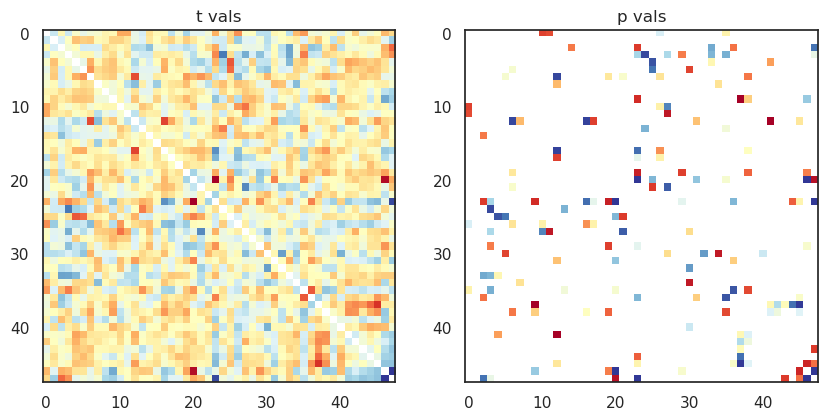

In [40]:
dif = np.array(corr_mat_l) - np.array(corr_mat_r)

t, p = stats.ttest_1samp(dif, popmean = 0)
p[p >= 0.05] = np.nan
count = np.sum(p <= 0.05)//2
print(count)

fig, axs = plt.subplots(1,2,figsize = (10,5))
axs[0].imshow(t, cmap = 'RdYlBu_r')
axs[0].set_title('t vals')
axs[1].imshow(p, cmap = 'RdYlBu_r', vmin = 0, vmax = 0.05)
axs[1].set_title('p vals')
plt.show()

**Exercise 11:**<a id="ex11"></a>  Looking at your p-values from exercise 10, how many connections significantly (p < 0.05, uncorrected) differentiate between the attend-left and attend-right conditions? 



**A:**  
86

**Plotting a connectome** <a id="connectome"></a>

Nilearn has some beautiful tools for plotting connectomes. [`plotting.plot_connectome`](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) takes in the node by node correlation matrix and a node by coordinate matrix and then creates a connectome. Thresholds can be used to only show strong connections. 

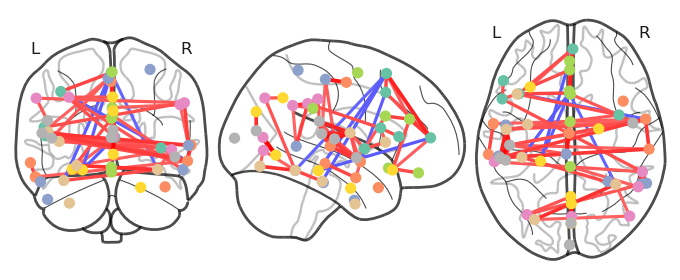

In [41]:
# Load the atlas.
atlas_filename = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_nii = atlas_filename.maps
atlas_data = atlas_filename.maps.get_fdata()
labels = np.unique(atlas_data)

# Iterate through all of the ROIs.
coords = []
for label_id in labels:
    
    # Skip the background.
    if label_id == 0:
        continue
        
    # Pull out the ROI of within the mask.    
    roi_mask = (atlas_data == label_id)
    
    # Create as a nifti object so it can be read by the cut coords algorithm.
    nii = nib.Nifti1Image(roi_mask.astype('int16'), atlas_nii.affine)
    
    # Find the center of mass of the connectome.
    coords.append(plotting.find_xyz_cut_coords(nii))
    
# Plot the connectome.
plotting.plot_connectome(correlation_matrix_mcg, coords, edge_threshold='95%')

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

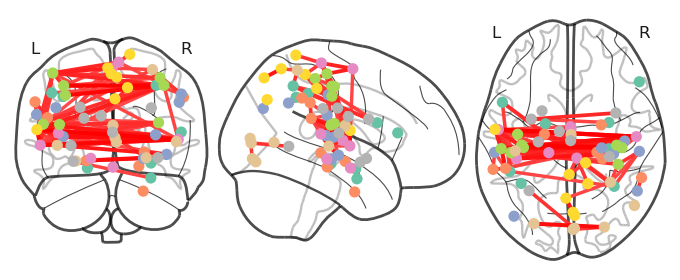

In [42]:
# Insert your code here.
# Load the atlas.
Jatlas = datasets.fetch_atlas_juelich('maxprob-thr25-2mm')
Jatlas_filename = Jatlas.maps
Jatlas_data = Jatlas.maps.get_fdata()
Jlabels = np.unique(Jatlas_data)

# Iterate through all of the ROIs.
Jcoords = []
for label_id in Jlabels:
    
    # Skip the background.
    if label_id == 0:
        continue
        
    # Pull out the ROI of within the mask.    
    roi_mask = (Jatlas_data == label_id)
    
    # Create as a nifti object so it can be read by the cut coords algorithm.
    nii = nib.Nifti1Image(roi_mask.astype('int16'), Jatlas_filename.affine)
    
    # Find the center of mass of the connectome.
    Jcoords.append(plotting.find_xyz_cut_coords(nii))
    
# Plot the connectome.
plotting.plot_connectome(correlation_measure.fit_transform([bold_J_l])[0], Jcoords[1:], edge_threshold='95%')

Connectome plot for Juelich for attend left

## Contributions <a id="contributions"></a>

B. Hutchinson provided data and provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 3/15/18  
Q. Lu add solution   
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19<br/>
X. Li improved figures in section 1.3 and 1.4      
T. Yates made edits for cmhn_s21  
E. Busch made edits for cmhn_s22, cmhn_s23